In [1]:
import jax
from jax import grad, jit, lax, random, vmap
from jax.experimental.ode import odeint
from functools import partial
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import evofr as ef

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
#import relative_fitness_gp
from ode_models import two_variant_model, three_variant_model

import matplotlib as mpl
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18

In [3]:
# Simulate three-variant SIR

## Defining model parameters
R0_wt = 1.4 # Basic reproduction number in wild type

gen_wt = 3.0 # Average length of infection (days): 1 / gam_wt
eta_T = (1 + 0.5) # Transmissibility increase
eta_E = 0.7 * eta_T # Escape fraction 

# Rest of quantities can be computed from the above
gam_wt =  1 / gen_wt
beta_wt = R0_wt * gam_wt

In [4]:
#####  Defining parameters and initial conditions
true_θ = (beta_wt, gam_wt, eta_T, eta_E)

# Simulate first wave with no variants
# S0, I_wt, I_ve, I_vt, R_wt, R_ve, Inc_wt, Inc_ve, Inc_vt
N = 100_000
u01 = jnp.array([0.999, 
                 0.0001, 0.0, 0.0, 
                 0.0, 0.0, 0.0,
                 0.0, 0.0, 0.0])
t1 = jnp.arange(35.)
Y1 = odeint(three_variant_model, u01, t1, true_θ)

# Simulate second wave with transmissibility variant
u02 = Y1[-1, :].at[3].add(1e-5)
t2 = jnp.arange(70.) + t1[-1] + 1
Y2 = odeint(three_variant_model, u02, t2, true_θ)

# Simulate third wave with escape variant
u03 = Y2[-1, :].at[2].add(1e-6)
t3 = jnp.arange(70.) + t2[-1] + 1
Y3 = odeint(three_variant_model, u03, t3, true_θ)

# Combine outputs and unpack
t = jnp.concatenate((t1, t2, t3))
Y = jnp.concatenate((Y1, Y2[1:,:], Y3[1:,:]), axis=0)

S, I_wt, I_ve,  I_vt = Y[:,0], Y[:, 1], Y[:, 2], Y[:, 3]
phi_wt, phi_ve, phi_vt  = Y[:, 4], Y[:, 5], Y[:,6]
Inc_wt, Inc_ve, Inc_vt = Y[:, 7], Y[:, 8], Y[:, 9]

In [21]:
FIG_PATH = "../manuscript/figures/components/"
#SUPP_PATH = "../manuscript/supplementary_figures/"

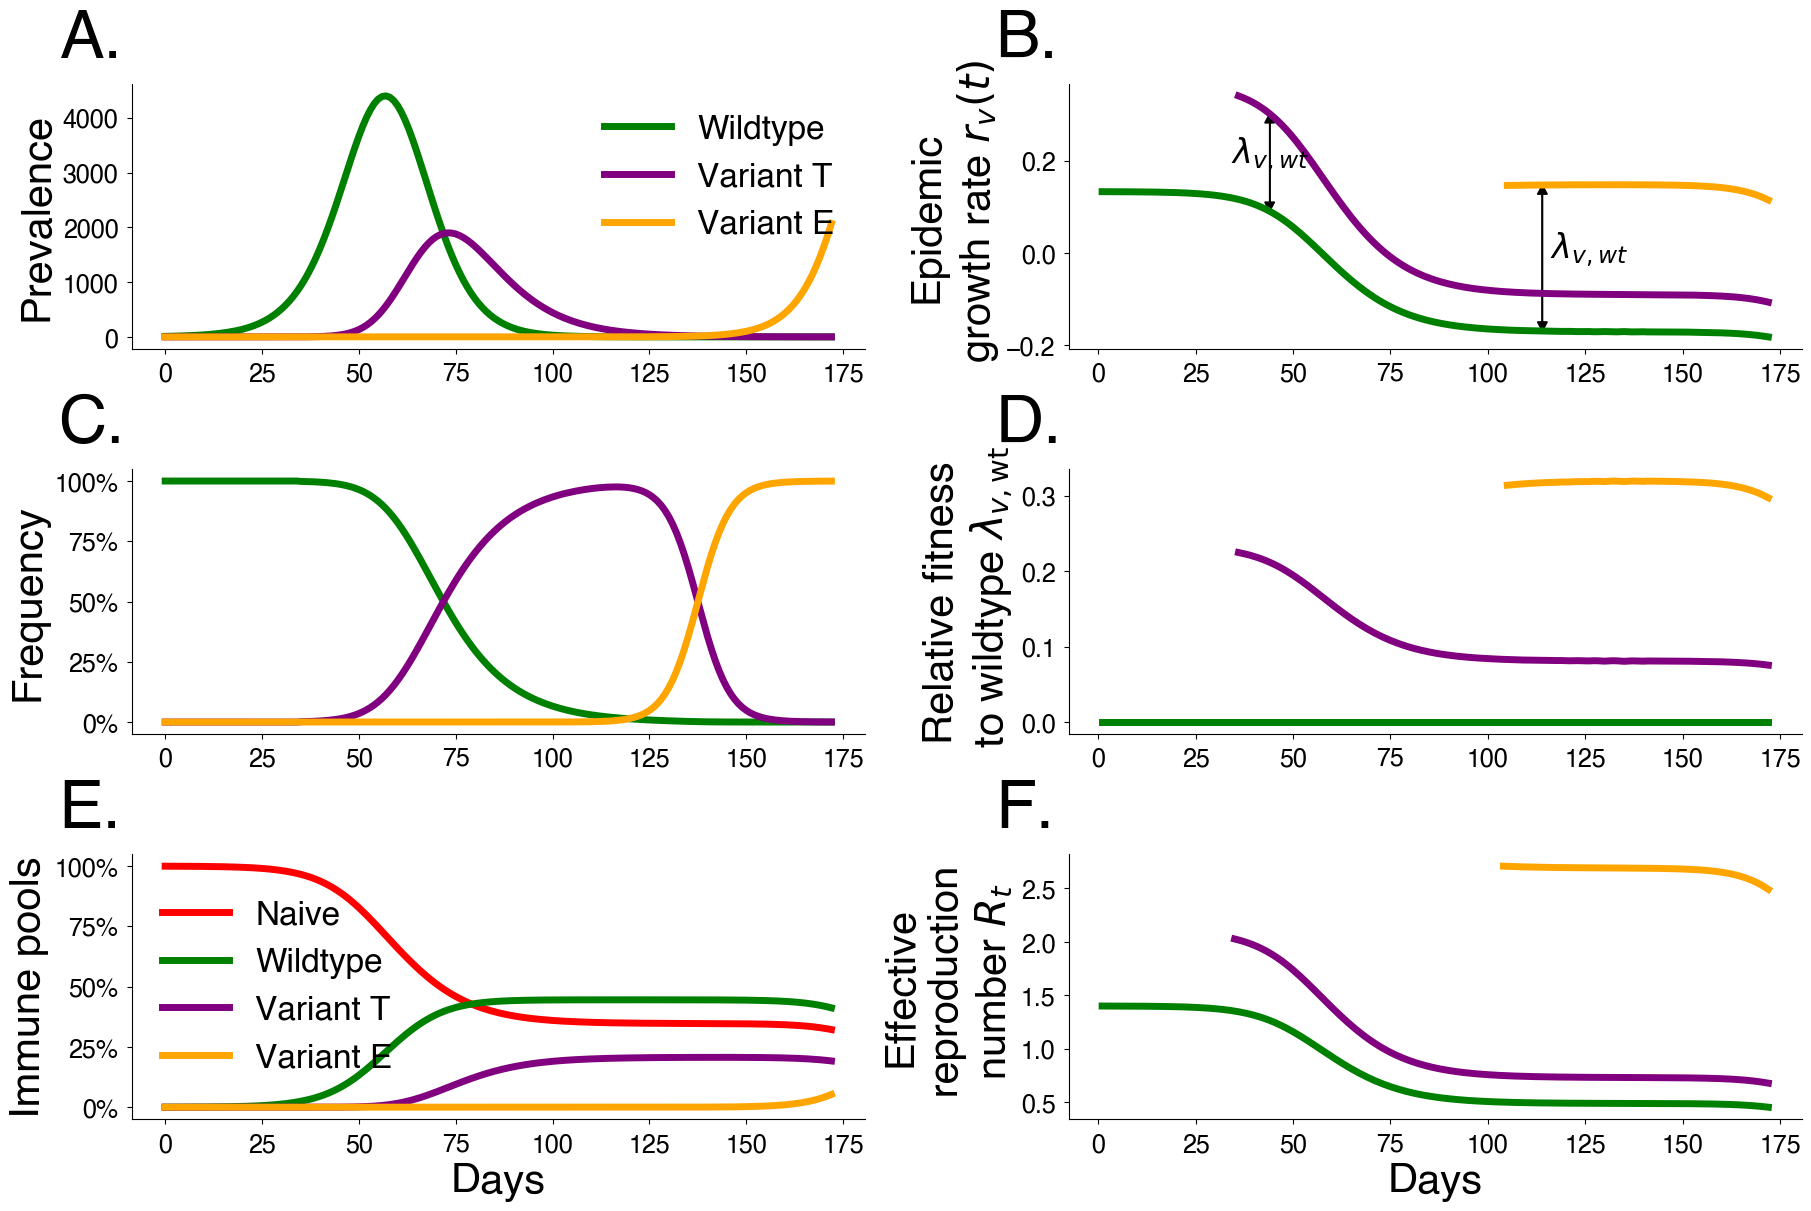

In [6]:
# Show prevalance, epidemic growth rate
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}

fig = plt.figure(figsize=(18., 12.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=3, width_ratios=[1.0, 1.0])

# Plotting prevalence
ax_prev = fig.add_subplot(spec[0, 0])
ax_prev.plot(N * I_wt, color=WT_COLOR, label=WT_LABEL)
ax_prev.plot(N * I_vt, color=VART_COLOR, label=VART_LABEL)
ax_prev.plot(N * I_ve, color=VARE_COLOR, label=VARE_LABEL)

ax_prev.set_ylabel("Prevalence")
ax_prev.legend(frameon=False)

# Plotting epidemic growth rate
def egr(Y):
    return jnp.diff(jnp.log(Y), prepend=jnp.nan)
    
ax_egr = fig.add_subplot(spec[0, 1])
ax_egr.plot(egr(I_wt), color=WT_COLOR)
ax_egr.plot(egr(I_vt), color=VART_COLOR)
ax_egr.plot(egr(I_ve), color=VARE_COLOR)

ax_egr.set_ylabel("Epidemic\n growth rate " + r"$r_v(t)$")

## Adding arrows
def add_arrows(ax, t, y1, y2, label, text_offset, horizontalalignment="left"):
    arrow_style = {
        "head_width": 2.5,
        "head_length": 0.02,
        "color":"k"
    }
    ax_egr.arrow(t, y1, dx=0, dy=y2-y1, **arrow_style, length_includes_head=True)
    ax_egr.arrow(t, y2, dx=0, dy=y1-y2, **arrow_style, length_includes_head=True)

    ax_egr.annotate(
        xy=(t, y1), 
        xytext=(t+text_offset, (y1+y2)/2),
        text=label,
        fontsize=24,
        horizontalalignment=horizontalalignment)
    
annotate_t1, annotate_t2 = int(t1[-1] + 10), int(t2[-1] + 10)
egr_wt, egr_vt, egr_ve = egr(I_wt), egr(I_vt), egr(I_ve)

add_arrows(ax_egr, annotate_t1, egr_wt[annotate_t1], egr_vt[annotate_t1], r"$\lambda_{v,wt}$", text_offset=-10)
add_arrows(ax_egr, annotate_t2, egr_wt[annotate_t2], egr_ve[annotate_t2], r"$\lambda_{v,wt}$", text_offset=2)

# Frequency
ax_freq = fig.add_subplot(spec[1, 0])
ax_freq.plot(I_wt / (I_wt + I_vt + I_ve), color=WT_COLOR, label=WT_LABEL)
ax_freq.plot(I_vt / (I_wt + I_vt + I_ve), color=VART_COLOR, label=VART_LABEL)
ax_freq.plot(I_ve / (I_wt + I_vt + I_ve), color=VARE_COLOR, label=VARE_LABEL)
ax_freq.set_ylabel("Frequency")
ax_freq.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Relative fitness
delta_wt = egr_wt - egr_wt
delta_ve = egr_ve - egr_wt
delta_vt = egr_vt - egr_wt

ind_wt = ~jnp.isnan(delta_wt)
ind_ve = ~jnp.isnan(delta_ve)
ind_vt = ~jnp.isnan(delta_vt)

ax_relfit = fig.add_subplot(spec[1, 1])
ax_relfit.plot(delta_wt, color=WT_COLOR, label=WT_LABEL)
ax_relfit.plot(delta_vt, color=VART_COLOR, label=VART_LABEL)
ax_relfit.plot(delta_ve, color=VARE_COLOR, label=VARE_LABEL)
ax_relfit.set_ylabel("Relative fitness\n to wildtype " + r"$\lambda_{v, \text{wt}}$")

# Add in immune pools
ax_immune = fig.add_subplot(spec[2, 0])
ax_immune.plot(S, color="red", label="Naive")
ax_immune.plot(phi_wt, color=WT_COLOR, label=WT_LABEL)
ax_immune.plot(phi_vt, color=VART_COLOR, label=VART_LABEL)
ax_immune.plot(phi_ve, color=VARE_COLOR, label=VARE_LABEL)
ax_immune.set_xlabel("Days")
ax_immune.set_ylabel("Immune pools")
ax_immune.legend(frameon=False)
ax_immune.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add in Rt
ax_rt = fig.add_subplot(spec[2, -1])
ax_rt.plot(
    jnp.where(ind_wt, beta_wt * S / gam_wt, jnp.nan), 
    color=WT_COLOR, 
    label=WT_LABEL
)
ax_rt.plot(
    jnp.where(ind_vt, beta_wt * eta_T * S  / gam_wt, jnp.nan), 
    color=VART_COLOR,
    label=VART_LABEL
)
ax_rt.plot(
    jnp.where(ind_ve, beta_wt * eta_T * (eta_E * phi_wt + eta_E * phi_wt  + S) / gam_wt, jnp.nan),
    color=VARE_COLOR,
    label=VARE_LABEL
)
ax_rt.set_xlabel("Days")
ax_rt.set_ylabel("Effective\n reproduction\n number " + r"$R_t$" )

import string
axes = [ax_prev, ax_egr, ax_freq, ax_relfit, ax_immune, ax_rt]
ax_labels = string.ascii_uppercase 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=48, weight='bold')
    
#TODO: Compute EGR by hand
#TODO: Comparing futures for variants with differnt properties at same starting point!

#Comment: Panel C things rise at similar point in time (?). 
    # How to highlight that different mechanim is explaining this difference?
    
fig.savefig(FIG_PATH + "splash_1.png")

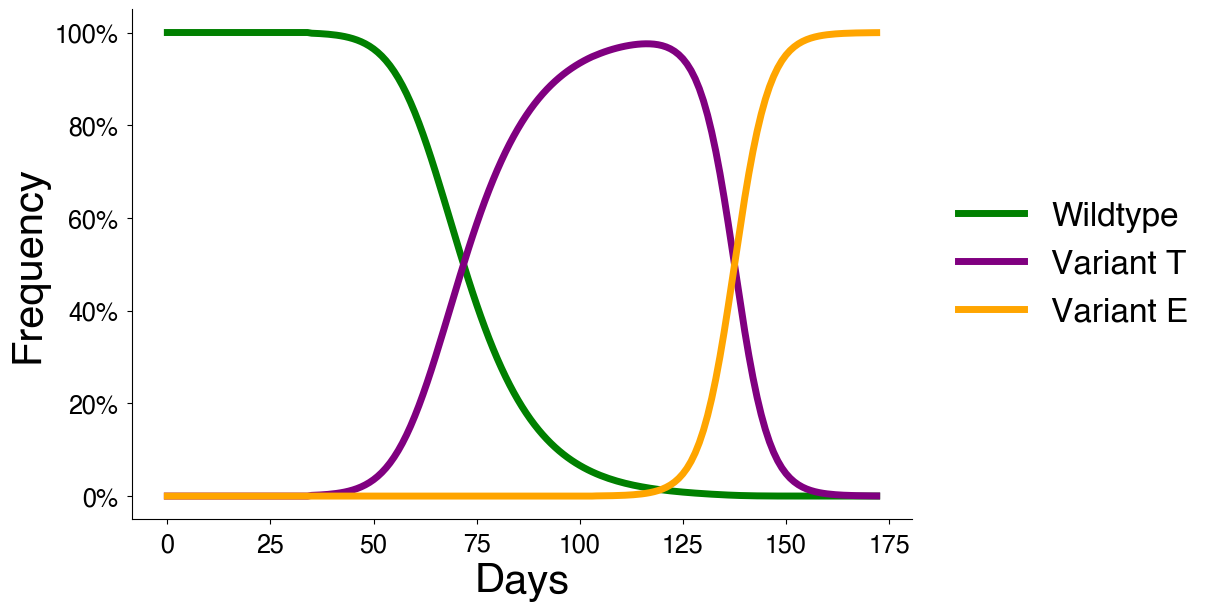

In [24]:
# Show prevalance, epidemic growth rate
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}

fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)

ax = fig.add_subplot(spec[0, 0])
ax.plot(I_wt / (I_wt + I_vt + I_ve), color=WT_COLOR, label=WT_LABEL)
ax.plot(I_vt / (I_wt + I_vt + I_ve), color=VART_COLOR, label=VART_LABEL)
ax.plot(I_ve / (I_wt + I_vt + I_ve), color=VARE_COLOR, label=VARE_LABEL)
ax.set_ylabel("Frequency")
ax.set_xlabel("Days")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    
fig.savefig(FIG_PATH + "frequency.svg")

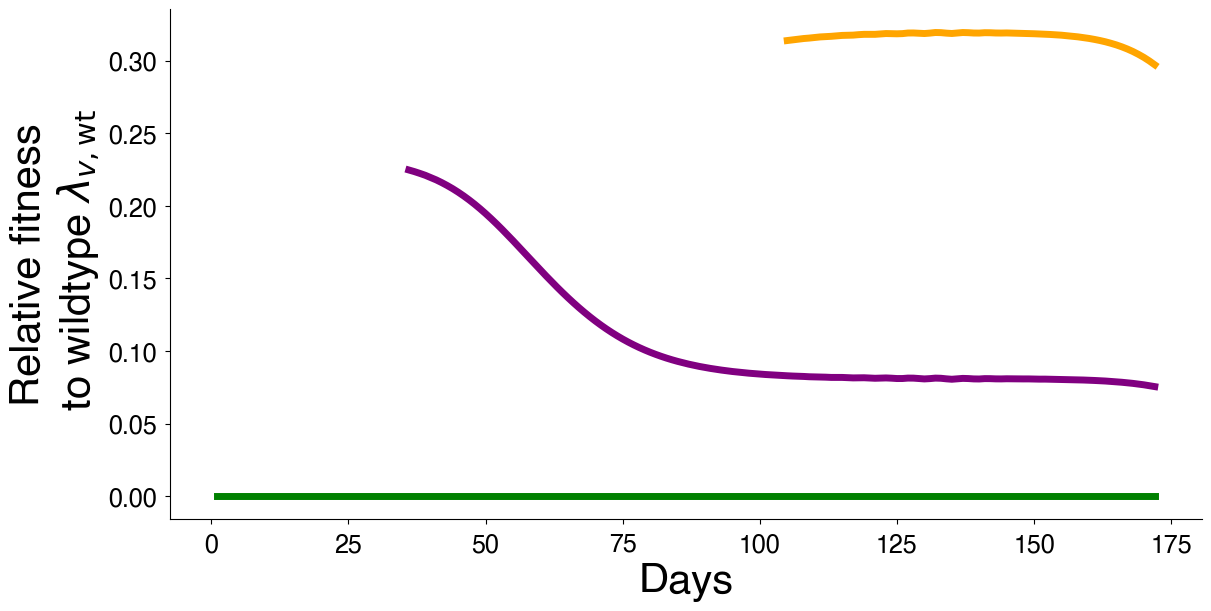

In [58]:
# Show prevalance, epidemic growth rate
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}

fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)

ax = fig.add_subplot(spec[0, 0])

# Relative fitness
delta_wt = egr_wt - egr_wt
delta_ve = egr_ve - egr_wt
delta_vt = egr_vt - egr_wt

ind_wt = ~jnp.isnan(delta_wt)
ind_ve = ~jnp.isnan(delta_ve)
ind_vt = ~jnp.isnan(delta_vt)

ax.plot(delta_wt, color=WT_COLOR, label=WT_LABEL)
ax.plot(delta_vt, color=VART_COLOR, label=VART_LABEL)
ax.plot(delta_ve, color=VARE_COLOR, label=VARE_LABEL)
ax.set_ylabel("Relative fitness\n to wildtype " + r"$\lambda_{v, \text{wt}}$")
ax.set_xlabel("Days")

fig.savefig(FIG_PATH + "relative-fitness.svg")

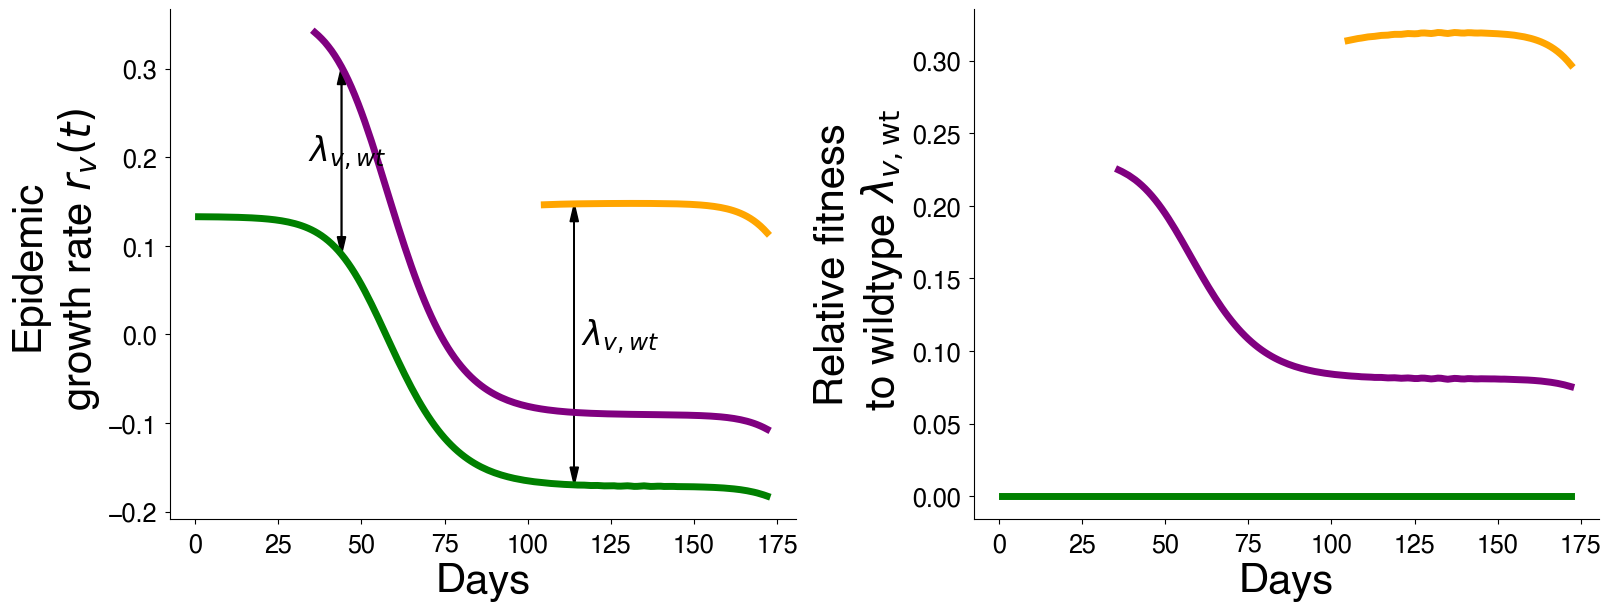

In [61]:
# Show prevalance, epidemic growth rate
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}

fig = plt.figure(figsize=(16., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1)


# Plotting epidemic growth rate
def egr(Y):
    return jnp.diff(jnp.log(Y), prepend=jnp.nan)
    
ax_egr = fig.add_subplot(spec[0, 0])
ax_egr.plot(egr(I_wt), color=WT_COLOR)
ax_egr.plot(egr(I_vt), color=VART_COLOR)
ax_egr.plot(egr(I_ve), color=VARE_COLOR)

ax_egr.set_ylabel("Epidemic\n growth rate " + r"$r_v(t)$")
ax_egr.set_xlabel("Days")

## Adding arrows
def add_arrows(ax, t, y1, y2, label, text_offset, horizontalalignment="left"):
    arrow_style = {
        "head_width": 2.5,
        "head_length": 0.02,
        "color":"k"
    }
    ax_egr.arrow(t, y1, dx=0, dy=y2-y1, **arrow_style, length_includes_head=True)
    ax_egr.arrow(t, y2, dx=0, dy=y1-y2, **arrow_style, length_includes_head=True)

    ax_egr.annotate(
        xy=(t, y1), 
        xytext=(t+text_offset, (y1+y2)/2),
        text=label,
        fontsize=24,
        horizontalalignment=horizontalalignment)
    
annotate_t1, annotate_t2 = int(t1[-1] + 10), int(t2[-1] + 10)
egr_wt, egr_vt, egr_ve = egr(I_wt), egr(I_vt), egr(I_ve)

add_arrows(ax_egr, annotate_t1, egr_wt[annotate_t1], egr_vt[annotate_t1], r"$\lambda_{v,wt}$", text_offset=-10)
add_arrows(ax_egr, annotate_t2, egr_wt[annotate_t2], egr_ve[annotate_t2], r"$\lambda_{v,wt}$", text_offset=2)



ax = fig.add_subplot(spec[0, 1])

# Relative fitness
delta_wt = egr_wt - egr_wt
delta_ve = egr_ve - egr_wt
delta_vt = egr_vt - egr_wt

ind_wt = ~jnp.isnan(delta_wt)
ind_ve = ~jnp.isnan(delta_ve)
ind_vt = ~jnp.isnan(delta_vt)

ax.plot(delta_wt, color=WT_COLOR, label=WT_LABEL)
ax.plot(delta_vt, color=VART_COLOR, label=VART_LABEL)
ax.plot(delta_ve, color=VARE_COLOR, label=VARE_LABEL)
ax.set_ylabel("Relative fitness\n to wildtype " + r"$\lambda_{v, \text{wt}}$")
ax.set_xlabel("Days")

fig.savefig(FIG_PATH + "relative-fitness-epidemic-growth.svg")

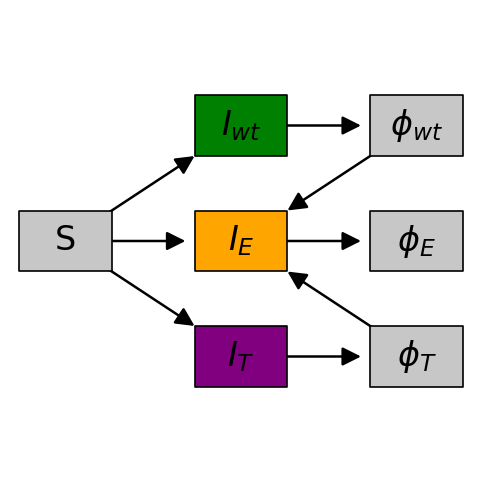

In [92]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.lines import Line2D
from matplotlib.path import Path

WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}
LABEL_MAP = {"S": r"$S$", 
             "I_wt": r"$I_{wt}$", "I_ve": r"$I_{E}$", "I_vt": r"$I_{T}$",
             "R_wt": r"$\phi_{wt}$", "R_ve": r"$\phi_{E}$", "R_vt": r"$\phi_{T}$",
            }


def plot_three_variant_dag(
    ax,
    *,
    color_map=COLOR_MAP,
    fallback_node_color="#777",
    node_size=(2, 1.3),         # (width, height) in axes coords
    node_edgecolor="black",
    node_linewidth=1.2,
    fontsize=24,
    fontfamily="DejaVu Sans",
    arrowstyle="-|>",
    arrowsize=28,
    linewidth=1.8,
    curved=0.15,
    show_labels=True,
    show_rates=False,
    show_incidence=False,
    title=None,
):
    """
    Draw the three-variant epidemic model as a DAG.

    Nodes:
      S, I_wt, I_ve, I_vt, R_wt, R_ve, R_vt, (Inc_wt, Inc_ve, Inc_vt optional)

    Edges:
      S -> I_wt (λ_wt), S -> I_ve (λ_ves), S -> I_vt (λ_vts)
      R_wt -> I_ve (λ_verw), R_vt -> I_ve (λ_vert)
      I_* -> R_* (γ_* recoveries)
      I_* -> Inc_* (dashed; incidence tallies), if show_incidence=True

    Colors:
      Wildtype group (I_wt, R_wt, Inc_wt)     -> color_map[WT_LABEL]
      Variant T group (I_vt, R_vt, Inc_vt)    -> color_map[VART_LABEL]
      Variant E group (I_ve, R_ve, Inc_ve)    -> color_map[VARE_LABEL]
      S is neutral -> fallback_node_color
    """
    ax.set_aspect("equal")
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis("off")

    # --- layout (hand-tuned so it looks nice) ---
    # columns:    S | Infectious | Recovered | Incidence
    # rows:       WT (top), VT (mid), VE (bottom)
    pos = {
        "S":      (1.2, 5.0),

        "I_wt":   (5.0, 7.5),
        "I_vt":   (5.0, 2.5),
        "I_ve":   (5.0, 5.0),

        "R_wt":   (8.8, 7.5),
        "R_vt":   (8.8, 2.5),
        "R_ve":   (8.8, 5.0),

        "Inc_wt": (9.0, 7.5),
        "Inc_vt": (9.0, 2.5),
        "Inc_ve": (9.0, 5.0),
    }

    # group membership for coloring
    group = {
        "I_wt": WT_LABEL, "R_wt": fallback_node_color, "Inc_wt": WT_LABEL,
        "I_vt": VART_LABEL, "R_vt": fallback_node_color, "Inc_vt": VART_LABEL,
        "I_ve": VARE_LABEL, "R_ve": fallback_node_color, "Inc_ve": VARE_LABEL,
    }

    # Which nodes to actually draw (allow hiding incidence)
    nodes = ["S", "I_wt", "I_vt", "I_ve", "R_wt", "R_vt", "R_ve"]
    if show_incidence:
        nodes += ["Inc_wt", "Inc_vt", "Inc_ve"]

    # --- helpers ---
    def draw_node(name, label=None, color=None):
        x, y = pos[name]
        w, h = node_size
        # draw as a rounded rectangle
        rect = Rectangle(
            (x - w/2, y - h/2), w, h,
            linewidth=node_linewidth,
            edgecolor=node_edgecolor,
            facecolor=color,
            zorder=2,
            joinstyle="round"
        )
        ax.add_patch(rect)
        if show_labels:
            ax.text(
                x, y, label or name,
                ha="center", va="center",
                fontsize=fontsize, family=fontfamily
            )

    def draw_arrow(a, b, text=None, style="solid", bend=0.0):
        (x1, y1), (x2, y2) = pos[a], pos[b]
        dx, dy = x2 - x1, y2 - y1

        # Optional curvature (positive bends counterclockwise)
        if bend != 0:
            # control point roughly at mid with offset perpendicular to the line
            mx, my = (x1 + x2) / 2, (y1 + y2) / 2
            nx, ny = -dy, dx
            ctrl = (mx + bend * nx, my + bend * ny)
            path = Path([ (x1,y1), ctrl, (x2,y2) ], [Path.MOVETO, Path.CURVE3, Path.CURVE3])
            patch = FancyArrowPatch(
                path=path,
                arrowstyle=arrowstyle,
                mutation_scale=arrowsize,
                lw=linewidth,
                linestyle="--" if style == "dashed" else "-",
                color="black",
                zorder=1,
            )
        else:
            patch = FancyArrowPatch(
                (x1, y1), (x2, y2),
                arrowstyle=arrowstyle,
                mutation_scale=arrowsize,
                lw=linewidth,
                linestyle="--" if style == "dashed" else "-",
                color="black",
                zorder=1,
                connectionstyle="arc3,rad=0",
                shrinkB=40,  # shrink at end
            )
        ax.add_patch(patch)

        if show_rates and text:
            # label near the midpoint
            tx, ty = (x1 + x2) / 2, (y1 + y2) / 2
            ax.text(tx, ty, text, fontsize=fontsize-1, family=fontfamily,
                    ha="center", va="bottom", rotation=0)

    # --- draw nodes ---
    for n in nodes:
        if n == "S":
            c = fallback_node_color
            lab = "S"
        else:
            grp = group.get(n, None)
            c = color_map.get(grp, fallback_node_color)
            # nicer labels for incidence boxes
            lab = LABEL_MAP.get(n, n)
        draw_node(n, lab, c)

    # --- draw edges ---
    # infections from S
    draw_arrow("S", "I_wt", text=r"$\lambda_{wt}$", bend=0)
    draw_arrow("S", "I_vt", text=r"$\lambda_{vts}$", bend=0)
    draw_arrow("S", "I_ve", text=r"$\lambda_{ves}$", bend=0)

    # immune-escape / cross-state infections
    draw_arrow("R_wt", "I_ve", text=r"$\lambda_{verw}$", bend=0)
    draw_arrow("R_vt", "I_ve", text=r"$\lambda_{vert}$", bend=0)

    # recoveries
    draw_arrow("I_wt", "R_wt", text=r"$\gamma_{wt}$")
    draw_arrow("I_vt", "R_vt", text=r"$\gamma_{vt}$")
    draw_arrow("I_ve", "R_ve", text=r"$\gamma_{ve}$")

    # incidence taps (dashed from Infectious to Inc_*)
    if show_incidence:
        draw_arrow("I_wt", "Inc_wt", text=r"$+\lambda_{wt}$", style="dashed")
        draw_arrow("I_vt", "Inc_vt", text=r"$+\lambda_{vts}$", style="dashed")
        # Inc_ve accrues from multiple sources; we summarize from I_ve
        draw_arrow("I_ve", "Inc_ve", text=r"$+\lambda_{ves}+\lambda_{verw}+\lambda_{vert}$", style="dashed")

    # --- legend ---
    legend_elems = [
        Line2D([0], [0], marker="s", linestyle="None", markersize=12,
               markerfacecolor=color_map[WT_LABEL], markeredgecolor=node_edgecolor, label=WT_LABEL),
        Line2D([0], [0], marker="s", linestyle="None", markersize=12,
               markerfacecolor=color_map[VART_LABEL], markeredgecolor=node_edgecolor, label=VART_LABEL),
        Line2D([0], [0], marker="s", linestyle="None", markersize=12,
               markerfacecolor=color_map[VARE_LABEL], markeredgecolor=node_edgecolor, label=VARE_LABEL),
        Line2D([0], [0], color="black", lw=linewidth, label="Flow"),
        Line2D([0], [0], color="black", lw=linewidth, linestyle="--", label="Incidence tally"),
    ]
    #ax.legend(handles=legend_elems, loc="upper left", frameon=False)

    if title:
        ax.set_title(title, fontsize=fontsize+2, family=fontfamily)

fig, ax = plt.subplots(figsize=(9, 6))
plot_three_variant_dag(
        ax,
        fallback_node_color="#c7c7c7",
        title=None
    )

fig.savefig(FIG_PATH + "dag.svg")

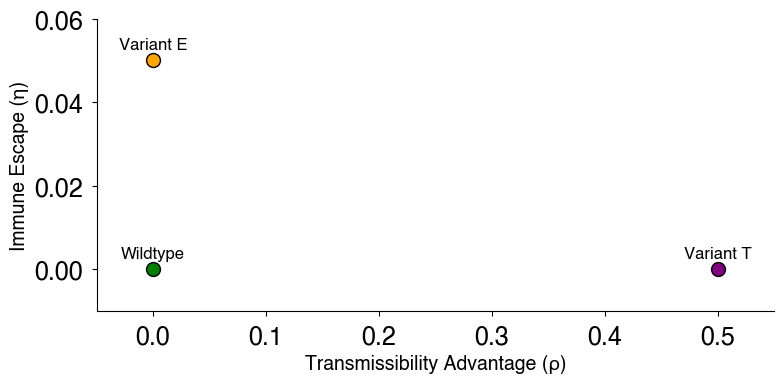

In [85]:
import matplotlib.pyplot as plt

# Define eta and rho for each variant
variants = ["Wildtype", "Variant T", "Variant E"]
rho = [0.0, 0.5, 0.0]   # Increase in transmissibility
eta = [0.0, 0.0, 0.05]  # Immune escape

# Define colors
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 4))
for i, variant in enumerate(variants):
    ax.scatter(
        rho[i],
        eta[i],
        color=COLOR_MAP[variant],
        edgecolor="black",
        s=100,
        zorder=3,
        label=variant
    )
    ax.text(
        rho[i],
        eta[i] + 0.002,
        variant,
        fontsize=12,
        ha='center',
        va='bottom'
    )

# Labeling and aesthetics
ax.set_xlabel("Transmissibility Advantage (ρ)", fontsize=14)
ax.set_ylabel("Immune Escape (η)", fontsize=14)
ax.set_xlim(-0.05, 0.55)
ax.set_ylim(-0.01, 0.06)
ax.spines[['top', 'right']].set_visible(False)
#ax.legend(frameon=False)
ax.grid(False)  # Turn off grid

plt.tight_layout()
plt.show()

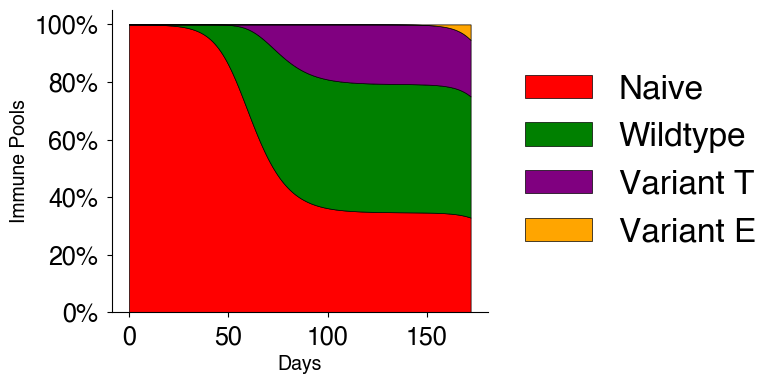

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# Compute scaling factor to ensure sum does not exceed 1.0
total_pool = S + phi_wt + phi_vt + phi_ve
scaling_factor = np.where(total_pool != 1.0, 1.0 / total_pool, 1.0)

# Apply scaling without mutating originals
S_scaled = S * scaling_factor
phi_wt_scaled = phi_wt * scaling_factor
phi_vt_scaled = phi_vt * scaling_factor
phi_ve_scaled = phi_ve * scaling_factor

# Colors
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"

# Plot
fig, ax = plt.subplots(figsize=(8, 4))

ax.stackplot(
    t[:-2],
    S_scaled,
    phi_wt_scaled,
    phi_vt_scaled,
    phi_ve_scaled,
    labels=["Naive", WT_LABEL, VART_LABEL, VARE_LABEL],
    colors=["red", WT_COLOR, VART_COLOR, VARE_COLOR],
    edgecolor="black",
    linewidth=0.5
)

ax.set_xlabel("Days", fontsize=14)
ax.set_ylabel("Immune Pools", fontsize=14)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Move legend to the right
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.show()

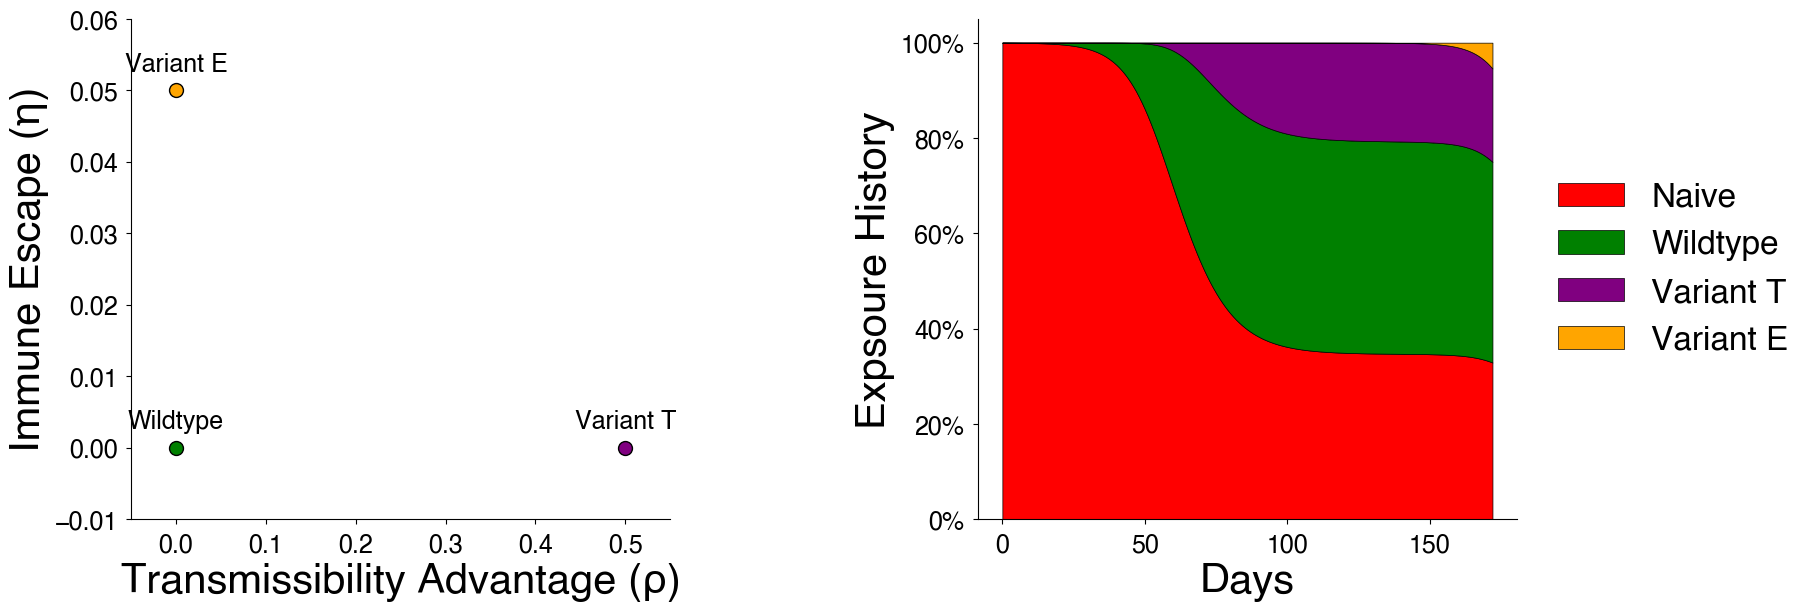

In [56]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

fig = plt.figure(figsize=(18., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1, wspace=0.2)

# Define eta and rho for each variant
variants = ["Wildtype", "Variant T", "Variant E"]
rho = [0.0, 0.5, 0.0]   # Increase in transmissibility
eta = [0.0, 0.0, 0.05]  # Immune escape

# Define colors
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}

# Create scatter plot
ax = fig.add_subplot(spec[0, 0])
for i, variant in enumerate(variants):
    ax.scatter(
        rho[i],
        eta[i],
        color=COLOR_MAP[variant],
        edgecolor="black",
        s=100,
        zorder=3,
        label=variant
    )
    ax.text(
        rho[i],
        eta[i] + 0.002,
        variant,
        fontsize=18,
        ha='center',
        va='bottom'
    )

# Labeling and aesthetics
ax.set_xlabel("Transmissibility Advantage (ρ)", fontsize=30)
ax.set_ylabel("Immune Escape (η)", fontsize=30)
ax.set_xlim(-0.05, 0.55)
ax.set_ylim(-0.01, 0.06)
ax.spines[['top', 'right']].set_visible(False)
ax.grid(False)  # Turn off grid

# Compute scaling factor to ensure sum does not exceed 1.0
total_pool = S + phi_wt + phi_vt + phi_ve
scaling_factor = np.where(total_pool != 1.0, 1.0 / total_pool, 1.0)

# Apply scaling without mutating originals
S_scaled = S * scaling_factor
phi_wt_scaled = phi_wt * scaling_factor
phi_vt_scaled = phi_vt * scaling_factor
phi_ve_scaled = phi_ve * scaling_factor

# Colors
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"

# Plot
ax = fig.add_subplot(spec[0, 1])

ax.stackplot(
    t[:-2],
    S_scaled,
    phi_wt_scaled,
    phi_vt_scaled,
    phi_ve_scaled,
    labels=["Naive", WT_LABEL, VART_LABEL, VARE_LABEL],
    colors=["red", WT_COLOR, VART_COLOR, VARE_COLOR],
    edgecolor="black",
    linewidth=0.5
)

ax.set_xlabel("Days", fontsize=30)
ax.set_ylabel("Expsoure History", fontsize=30)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Move legend to the right
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

fig.savefig(FIG_PATH + "phenotype_immunity.svg")